In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Experimental Setup (Random Label Permutation)

In [ ]:
class PermutedLabelsDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, num_tasks, samples_per_task):
        self.base_dataset = base_dataset
        self.num_tasks = num_tasks
        self.samples_per_task = samples_per_task

        # Pre-generate random label permutations
        self.label_mappings = [np.random.permutation(len(base_dataset.classes))
                              for _ in range(num_tasks)]

    def __len__(self):
        return self.num_tasks * self.samples_per_task

    def __getitem__(self, idx):
        task_id = idx // self.samples_per_task
        local_idx = idx % self.samples_per_task
        image, original_label = self.base_dataset[local_idx]
        permuted_label = self.label_mappings[task_id][original_label]
        return image, permuted_label

In [ ]:
# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

num_tasks = 50
samples_per_task = 1200
permuted_dataset = PermutedLabelsDataset(full_dataset, num_tasks, samples_per_task)
dataloader = torch.utils.data.DataLoader(permuted_dataset, batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:01<00:00, 97.8MB/s]


# 2. SLD Model Implementation

In [ ]:
class SLDLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_theta=0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.sigma_theta = sigma_theta

        # Learnable parameters
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))

        # Learnable δ (initialized to 1)
        self.delta_weight = nn.Parameter(torch.ones_like(self.weight))
        self.delta_bias = nn.Parameter(torch.ones_like(self.bias))

        self.register_buffer('weight_0', 0.1*torch.randn_like(self.weight))
        self.register_buffer('bias_0', 0.1*torch.randn_like(self.bias))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # Constrain using softplus
        delta_weight = torch.nn.functional.softplus(self.delta_weight)
        delta_bias = torch.nn.functional.softplus(self.delta_bias)

        gamma_weight = torch.exp(-0.5 * delta_weight)
        gamma_bias = torch.exp(-0.5 * delta_bias)

        # Numerical stability in sqrt
        sqrt_term_weight = torch.sqrt(1 - gamma_weight**2 + 1e-6)
        sqrt_term_bias = torch.sqrt(1 - gamma_bias**2 + 1e-6)

        weight_hat = gamma_weight * self.weight + sqrt_term_weight * self.weight_0
        bias_hat = gamma_bias * self.bias + sqrt_term_bias * self.bias_0

        # Add noise (detached from γ gradient)
        epsilon_w = torch.randn_like(weight_hat).detach()
        epsilon_b = torch.randn_like(bias_hat).detach()
        weight_noisy = weight_hat + sqrt_term_weight.detach() * self.sigma_theta * epsilon_w
        bias_noisy = bias_hat + sqrt_term_bias.detach() * self.sigma_theta * epsilon_b

        return nn.functional.linear(x, weight_noisy, bias_noisy)

class SLDNet(nn.Module):
    def __init__(self, sigma_theta=0.1):
        super().__init__()
        # Convolutional backbone
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        # Calculate output size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR-10 size
            conv_output = self.conv(dummy_input)
            self.flatten_size = conv_output.shape[1]

        # SLD linear layers
        self.sld_layers = nn.Sequential(
            SLDLinear(self.flatten_size, 256, sigma_theta),
            nn.ReLU(),
            SLDLinear(256, 10, sigma_theta)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.sld_layers(x)

# 3. Training Loop

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SLDNet(sigma_theta=0.1).to(device)

losses = []

# Parameter groups
theta_params = []
delta_params = []
for name, param in model.named_parameters():
    if 'delta' in name:
        delta_params.append(param)
    else:
        theta_params.append(param)

# Lower learning rate for δ
optimizer = optim.Adam([
    {'params': theta_params, 'lr': 1e-4},
    {'params': delta_params, 'lr': 1e-6}  # Reduced from 1e-5
])
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Gradient checks
        if torch.isnan(loss).any():
            print("NaN loss detected at step", batch_idx)
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        losses.append(loss.item())

        # Monitoring
        if batch_idx % 100 == 0:
            with torch.no_grad():
                preds = outputs.argmax(dim=1)
                acc = (preds == targets).float().mean().item()
            print(f'Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item():.4f} | Acc: {acc:.2f}')


Epoch: 0 | Batch: 0 | Loss: 9.1989 | Acc: 0.06
Epoch: 0 | Batch: 100 | Loss: 4.9149 | Acc: 0.12
Epoch: 0 | Batch: 200 | Loss: 2.7541 | Acc: 0.06
Epoch: 0 | Batch: 300 | Loss: 2.4011 | Acc: 0.12
Epoch: 0 | Batch: 400 | Loss: 2.3775 | Acc: 0.19
Epoch: 0 | Batch: 500 | Loss: 2.3850 | Acc: 0.12
Epoch: 0 | Batch: 600 | Loss: 2.5291 | Acc: 0.03
Epoch: 0 | Batch: 700 | Loss: 2.2947 | Acc: 0.06
Epoch: 0 | Batch: 800 | Loss: 2.3682 | Acc: 0.03
Epoch: 0 | Batch: 900 | Loss: 2.3246 | Acc: 0.16
Epoch: 0 | Batch: 1000 | Loss: 2.3440 | Acc: 0.00
Epoch: 0 | Batch: 1100 | Loss: 2.3659 | Acc: 0.09
Epoch: 0 | Batch: 1200 | Loss: 2.3431 | Acc: 0.03
Epoch: 0 | Batch: 1300 | Loss: 2.2963 | Acc: 0.03
Epoch: 0 | Batch: 1400 | Loss: 2.2766 | Acc: 0.06
Epoch: 0 | Batch: 1500 | Loss: 2.3220 | Acc: 0.12
Epoch: 0 | Batch: 1600 | Loss: 2.2940 | Acc: 0.09
Epoch: 0 | Batch: 1700 | Loss: 2.3022 | Acc: 0.16
Epoch: 0 | Batch: 1800 | Loss: 2.3108 | Acc: 0.12
Epoch: 1 | Batch: 0 | Loss: 2.3191 | Acc: 0.06
Epoch: 1 | Batc

# 4. Evaluation (Per-Task Accuracy)

In [ ]:
model.eval()
task_accuracies = []

with torch.no_grad():
    for task_id in range(num_tasks):
        correct = 0
        total = 0
        start_idx = task_id * samples_per_task
        end_idx = (task_id+1) * samples_per_task

        for idx in range(start_idx, end_idx, 100):
            image, label = permuted_dataset[idx]
            image = image.unsqueeze(0).to(device)
            output = model(image)
            pred = output.argmax(dim=1)
            correct += (pred == label).item()
            total += 1

        task_acc = correct / total
        task_accuracies.append(task_acc)
        print(f'Task {task_id} Accuracy: {task_acc:.4f}')

print(f'Average Accuracy: {np.mean(task_accuracies):.4f}')

Task 0 Accuracy: 0.0000
Task 1 Accuracy: 0.0000
Task 2 Accuracy: 0.2500
Task 3 Accuracy: 0.0833
Task 4 Accuracy: 0.0833
Task 5 Accuracy: 0.0000
Task 6 Accuracy: 0.0833
Task 7 Accuracy: 0.0833
Task 8 Accuracy: 0.0000
Task 9 Accuracy: 0.0000
Task 10 Accuracy: 0.3333
Task 11 Accuracy: 0.1667
Task 12 Accuracy: 0.0833
Task 13 Accuracy: 0.0833
Task 14 Accuracy: 0.1667
Task 15 Accuracy: 0.0833
Task 16 Accuracy: 0.0833
Task 17 Accuracy: 0.1667
Task 18 Accuracy: 0.0000
Task 19 Accuracy: 0.1667
Task 20 Accuracy: 0.0000
Task 21 Accuracy: 0.0000
Task 22 Accuracy: 0.1667
Task 23 Accuracy: 0.1667
Task 24 Accuracy: 0.2500
Task 25 Accuracy: 0.1667
Task 26 Accuracy: 0.0000
Task 27 Accuracy: 0.0833
Task 28 Accuracy: 0.1667
Task 29 Accuracy: 0.1667
Task 30 Accuracy: 0.0000
Task 31 Accuracy: 0.0833
Task 32 Accuracy: 0.0833
Task 33 Accuracy: 0.1667
Task 34 Accuracy: 0.0000
Task 35 Accuracy: 0.1667
Task 36 Accuracy: 0.0000
Task 37 Accuracy: 0.1667
Task 38 Accuracy: 0.0833
Task 39 Accuracy: 0.0000
Task 40 Ac

# 5. Visualization

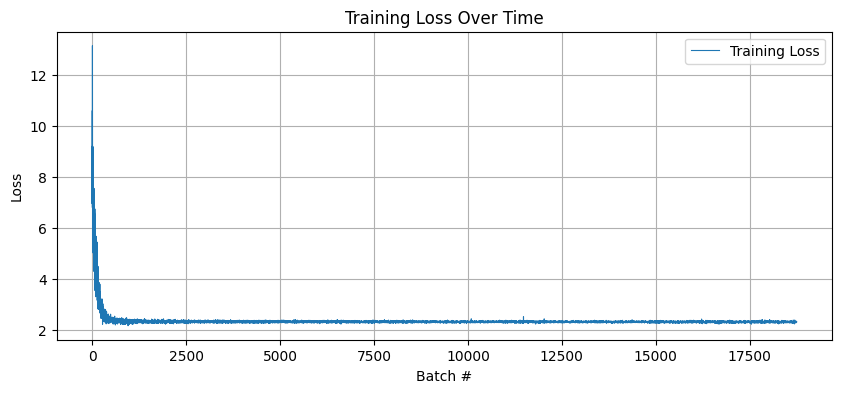

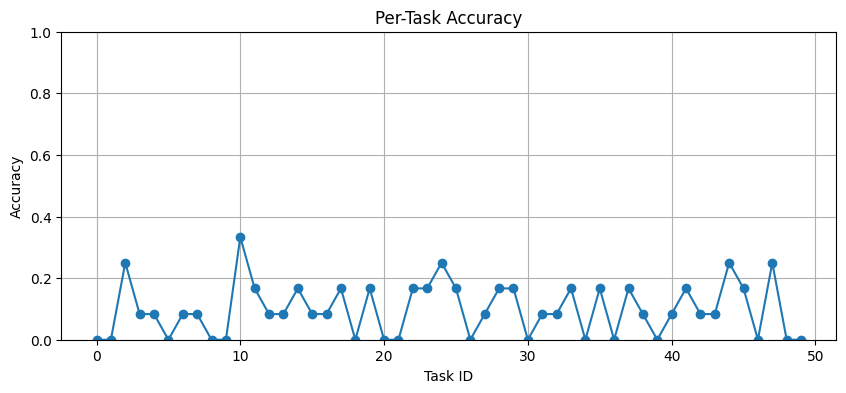

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(losses, label="Training Loss", linewidth=0.8)
plt.title("Training Loss Over Time")
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(task_accuracies, marker='o')
plt.title("Per-Task Accuracy")
plt.xlabel("Task ID")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1.0)
plt.show()

